I have simulated $100\,000$ games with four `RandomBot` players to generate a dataset.

In [111]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns

In [112]:
logs = pd.read_csv("game_logs/GameLogs.csv")
logs.head()

,game_id,round_id,action_type,active_player,bet_type,camel,camel_c_0_location,camel_c_0_stack_location,camel_c_1_location,camel_c_1_stack_location,...,player_1_trap_location,player_1_trap_type,player_2_coins,player_2_trap_location,player_2_trap_type,player_3_coins,player_3_trap_location,player_3_trap_type,trap_location,trap_type
0,0,0,NaN,NaN,NaN,NaN,0,1,1,0,...,NaN,NaN,2,NaN,NaN,2,NaN,NaN,NaN,NaN
1,0,1,move_trap,0.0,NaN,NaN,0,1,1,0,...,NaN,NaN,2,NaN,NaN,2,NaN,NaN,12.0,1.0
2,0,2,move_camel,1.0,NaN,c_1,0,1,2,0,...,NaN,NaN,2,NaN,NaN,2,NaN,NaN,NaN,NaN
3,0,3,move_trap,2.0,NaN,NaN,0,1,2,0,...,NaN,NaN,2,9.0,-1.0,2,NaN,NaN,9.0,-1.0
4,0,4,move_trap,3.0,NaN,NaN,0,1,2,0,...,NaN,NaN,2,9.0,-1.0,2,3.0,-1.0,3.0,-1.0


I'm interested in only the first and last entry of each game, i.e the starting and ending positions of the camels, respectively.

In [113]:
game_starts = logs.sort_values(["game_id", "round_id"]).groupby("game_id").nth(0)
game_ends = logs.sort_values(["game_id", "round_id"]).groupby("game_id").nth(-1)

In [114]:
game_starts.head()

,game_id,round_id,action_type,active_player,bet_type,camel,camel_c_0_location,camel_c_0_stack_location,camel_c_1_location,camel_c_1_stack_location,...,player_1_trap_location,player_1_trap_type,player_2_coins,player_2_trap_location,player_2_trap_type,player_3_coins,player_3_trap_location,player_3_trap_type,trap_location,trap_type
0,0,0,NaN,NaN,NaN,NaN,0,1,1,0,...,NaN,NaN,2,NaN,NaN,2,NaN,NaN,NaN,NaN
39,1,0,NaN,NaN,NaN,NaN,0,1,2,2,...,NaN,NaN,2,NaN,NaN,2,NaN,NaN,NaN,NaN
114,2,0,NaN,NaN,NaN,NaN,2,2,1,0,...,NaN,NaN,2,NaN,NaN,2,NaN,NaN,NaN,NaN
191,3,0,NaN,NaN,NaN,NaN,0,0,2,0,...,NaN,NaN,2,NaN,NaN,2,NaN,NaN,NaN,NaN
279,4,0,NaN,NaN,NaN,NaN,0,0,2,1,...,NaN,NaN,2,NaN,NaN,2,NaN,NaN,NaN,NaN


In [115]:
game_ends[['player_0_coins', 'player_1_coins', 'player_2_coins', 'player_3_coins']].head()

,player_0_coins,player_1_coins,player_2_coins,player_3_coins
38,5,15,1,6
113,16,10,11,5
190,11,16,10,15
278,12,4,27,7
358,19,18,13,9


Because camel positions consist of both track and stack positions, I will create a new value for the camel position, defined as:

$$ P = 10 \cdot pos_{track} + pos_{stack} $$

This ensures that camels stacked on top of each other will be treated accordingly.

In [116]:
def get_camel_pos(camel_id, dat):
    track_loc = "camel_" + camel_id + "_location"
    stack_loc = "camel_" + camel_id + "_stack_location"
    return dat[track_loc] * 10 + dat[stack_loc] 

In [117]:
start_positions = pd.DataFrame({
    camel_id: get_camel_pos(camel_id, game_starts) for
    camel_id in ["c_1", "c_2", "c_3", "c_4"]})

end_positions = pd.DataFrame({
    camel_id: get_camel_pos(camel_id, game_ends) for
    camel_id in ["c_1", "c_2", "c_3", "c_4"]})

In [118]:
start_positions.head()

,c_1,c_2,c_3,c_4
0,10,0,3,2
39,22,21,20,0
114,10,20,21,0
191,20,10,12,11
279,21,11,20,10


In [119]:
end_positions.head()

,c_1,c_2,c_3,c_4
38,160,150,151,80
113,131,151,130,160
190,120,150,160,151
278,140,170,150,101
358,160,140,142,141


The camels' relative places for each game can be obtained with `numpy.argsort`. It needs to be called twice as `argsort` returns the indices with which an array would be sorted, e.g. the $3^{rd}$ value of `np.argsort(x)` indicates the $3^{rd}$ largest value in the original array $x$. Therefore, $np.argsort(np.argsort(x))$ describes the order of each of the values in the original array $x$. 

In [120]:
start_positions_index = start_positions.apply(lambda x: np.argsort(np.argsort(-x)) + 1, axis=1)
start_positions_index.head()

,c_1,c_2,c_3,c_4
0,1,4,2,3
39,1,2,3,4
114,3,2,1,4
191,1,4,2,3
279,1,3,2,4


In [121]:
end_positions_index = end_positions.apply(lambda x: np.argsort(np.argsort(-x)) + 1, axis=1)
end_positions_index.head()

,c_1,c_2,c_3,c_4
38,1,3,2,4
113,3,2,4,1
190,4,3,1,2
278,3,1,2,4
358,1,4,2,3


For each of the camels, I can now look at the co-occurrence of positions, i.e. how often does a camel start at position $i$ and end at position $j$?

Because all camels in this analysis are identical, their respective co-occurrence matrices can simply be added together.

In [122]:
def get_cooccurrence_matrix(camel_id):
    return pd.crosstab(
        index=start_positions_index[camel_id].values, 
        columns=end_positions_index[camel_id].values)

camel_pos = get_cooccurrence_matrix("c_1") + \
    get_cooccurrence_matrix("c_2") + \
    get_cooccurrence_matrix("c_3") + \
    get_cooccurrence_matrix("c_4")

camel_pos.columns.name = "End"
camel_pos.index.name = "Start"

camel_pos

End,1,2,3,4
Start,,,,
1,1369,1335,1270,1026
2,1282,1315,1297,1106
3,1206,1227,1293,1274
4,1143,1123,1140,1594


The result is the following heatmap. Camels that begin in first place have a tendency to 

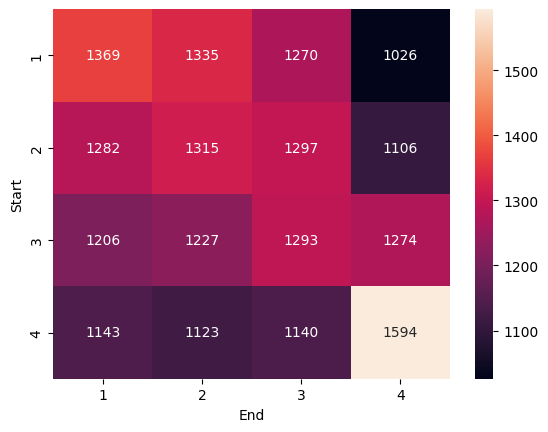

In [123]:
sns.heatmap(camel_pos, annot=True, fmt="g");

<Axes: xlabel='End', ylabel='Start'>

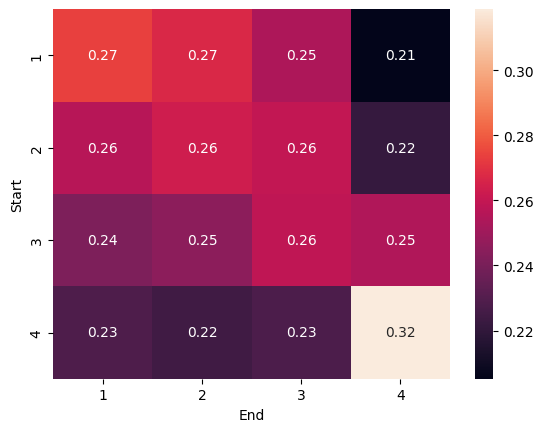

In [124]:
# Normalize by column
camel_pos_normalized = camel_pos.div(camel_pos.sum(axis=0), axis=1)

# Plot the normalized heatmap
sns.heatmap(camel_pos_normalized, annot=True, fmt=".2f")